<a href="https://colab.research.google.com/github/yoshivarma/DataScience/blob/main/Multinomial_Naive_Bayes_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MULTINOMIAL NAIVE BAYES ALGORITHM


In [1]:
from collections import Counter
import math
from math import log


In [2]:
import re
import os
import glob
import random
import numpy as np
from nltk.corpus import stopwords
import nltk

REPLACE_NO_SPACE = re.compile("[._;:!`¦\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
nltk.download('stopwords')  

def preprocess_text(text):
	stop_words = set(stopwords.words('english'))
	text = REPLACE_NO_SPACE.sub("", text)
	text = REPLACE_WITH_SPACE.sub(" ", text)
	text = re.sub(r'\d+', '', text)
	text = text.lower()
	words = text.split()
	return [w for w in words if w not in stop_words]

def load_training_set(percentage_positives, percentage_negatives):
  
  vocab = set()
  positive_instances = []
  negative_instances = []
  for filename in glob.glob("/content/drive/Othercomputers/My MacBook Air/Spring_2022/hw2/train/pos/*.txt"):
    if random.random() > percentage_positives:
      continue
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
      contents = f.read()
      contents = preprocess_text(contents)
      positive_instances.append(contents)
      vocab = vocab.union(set(contents))
  for filename in glob.glob("/content/drive/Othercomputers/My MacBook Air/Spring_2022/hw2/train/neg/*.txt"):
    if random.random() > percentage_negatives:
      continue
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
      contents = f.read()
      contents = preprocess_text(contents)
      negative_instances.append(contents)
      vocab = vocab.union(set(contents))	
  return positive_instances, negative_instances, vocab

def load_test_set(percentage_positives, percentage_negatives):
	positive_instances = []
	negative_instances = []
	for filename in glob.glob("/content/drive/Othercomputers/My MacBook Air/Spring_2022/hw2/test/pos/*.txt"):
		if random.random() > percentage_positives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			positive_instances.append(contents)
	for filename in glob.glob("/content/drive/Othercomputers/My MacBook Air/Spring_2022/hw2/test/neg/*.txt"):
		if random.random() > percentage_negatives:
			continue
		with open(os.path.join(os.getcwd(), filename), 'r') as f:
			contents = f.read()
			contents = preprocess_text(contents)
			negative_instances.append(contents)
	return positive_instances, negative_instances
		


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Question - 1

In [3]:
def counter_table(x_train):
  word_counts = {}
  x_sum = 0
  for doc in x_train:
    counts = Counter(doc)
    for word, count in counts.items():
      if word in word_counts.keys():
        word_counts[word] += count
      else:
        word_counts[word] = count
      x_sum = x_sum + count
  return word_counts, x_sum

In [4]:
def classify_new_document(test_document, pos_train, neg_train, pos_word_counts, pos_sum, neg_sum, neg_word_counts):
  
  pos_probability = 1
  neg_probability = 1


  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = (pos_word_counts[word]/pos_sum) * pos_probability
    else:
      pos_probability = 0
    if word in neg_word_counts.keys():
      neg_probability = (neg_word_counts[word]/neg_sum) * neg_probability
    else:
      neg_probability = 0

  pos_test_probability = pos_probability * pos_label_prob
  neg_test_probability = neg_probability * neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [5]:
def evaluation_metrics(x, y):
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(x, y)  
  (pos_test, neg_test) = load_test_set(x, y)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document in pos_test:
    test_value = classify_new_document(test_document, pos_train, neg_train, pos_word_counts, pos_sum, neg_sum, neg_word_counts)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document in neg_test:
    test_value = classify_new_document(test_document, pos_train, neg_train, pos_word_counts, pos_sum, neg_sum, neg_word_counts)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0]) 

  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])

  return accuracy, confusion_matrix, precision, recall

In [7]:
accuracy, confusion_matrix, precision, recall = evaluation_metrics(0.2, 0.2)

In [8]:
accuracy

0.5275974025974026

In [9]:
confusion_matrix

matrix([[ 159, 2285],
        [  43, 2441]])

In [10]:
precision

0.7871287128712872

In [11]:
recall

0.06505728314238952

In [12]:
def classify_new_document_log(test_document, pos_train, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum):
  
  pos_probability_log = 0
  neg_probability_log = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ len(pos_train)+len(neg_train)
  pos_label_prob = log(pos_label_prob)
  neg_label_prob = len(neg_train)/ len(pos_train)+len(neg_train)
  neg_label_prob = log(neg_label_prob)
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = (pos_word_counts[word]/pos_sum)
      pos_probability = log(pos_probability)
      pos_probability_log = pos_probability_log +pos_probability

    if word in neg_word_counts.keys():
      neg_probability = (neg_word_counts[word]/neg_sum) 
      neg_probability = log(neg_probability)
      neg_probability_log = neg_probability_log +neg_probability

  pos_test_probability = pos_probability_log + pos_label_prob
  neg_test_probability = neg_probability_log + neg_label_prob
  if pos_test_probability >neg_test_probability:
    return 1
  else:
    return 0


In [13]:
def evaluation_metrics_log(x, y):
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(x, y)  
  (pos_test, neg_test) = load_test_set(x, y)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document1 in pos_test:
    test_value = classify_new_document_log(test_document1, pos_train, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document2 in neg_test:
    test_value = classify_new_document_log(test_document2, pos_train, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0])
   
  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])
  

  return accuracy, confusion_matrix, precision, recall 

In [14]:
accuracy_log, confusion_matrix_log, precision_log, recall_log = evaluation_metrics_log(0.2, 0.2)

In [15]:
accuracy_log

0.5766640253565769

In [16]:
confusion_matrix_log

matrix([[1251, 1317],
        [ 820, 1660]])

In [17]:
precision_log

0.6040560115886046

In [18]:
recall_log

0.4871495327102804

Question - 2


In [19]:
def classify_new_document_laplace(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum):
  
  pos_probability = 0
  neg_probability = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = log((pos_word_counts[word] + 1)/(pos_sum + len(vocab))) + pos_probability
    else:
      pos_probability = log(1/ (pos_sum + len(vocab))) + pos_probability
    if word in neg_word_counts.keys():
      neg_probability = log((neg_word_counts[word]+1)/ (neg_sum + len(vocab))) + neg_probability
    else:
      neg_probability = log(1/ (neg_sum + len(vocab))) + neg_probability

  pos_test_probability = pos_probability + pos_label_prob
  neg_test_probability = neg_probability + neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [20]:
def evaluation_metrics_laplace(x, y):
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(x, y)  
  (pos_test, neg_test) = load_test_set(x, y)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document in pos_test:
    test_value = classify_new_document_laplace(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document in neg_test:
    test_value = classify_new_document_laplace(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0])
  

  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])

  return accuracy, confusion_matrix, precision, recall

In [21]:
accuracy_lap, confusion_matrix_lap, precision_lap, recall_lap= evaluation_metrics_laplace(0.2, 0.2)

In [22]:
accuracy_lap

0.8213854208618606

In [23]:
confusion_matrix_lap

matrix([[1955,  581],
        [ 306, 2124]])

In [24]:
precision_lap

0.8646616541353384

In [25]:
recall_lap

0.7708990536277602

In [26]:
def classify_new_document_laplace_alpha(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum, a):
  
  pos_probability = 0
  neg_probability = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = log((pos_word_counts[word] + a)/(pos_sum + a * len(vocab))) + pos_probability
    else:
      pos_probability = log(a/ (pos_sum + a * len(vocab))) + pos_probability
    if word in neg_word_counts.keys():
      neg_probability = log((neg_word_counts[word] + a)/(neg_sum + a * len(vocab))) + neg_probability
    else:
      neg_probability = log(a/ (neg_sum + a * len(vocab))) + neg_probability

  pos_test_probability = pos_probability + pos_label_prob
  neg_test_probability = neg_probability + neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [27]:
def evaluation_metrics_laplace_alpha(x, y):
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(x, y)  
  (pos_test, neg_test) = load_test_set(x, y)
  
  #initializing factors for accuracy, pecision, and recall
  accuracy_table = []

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  a = 0.0001
  for i in range(8):
    pos_accuracy_counter = 0
    neg_accuracy_counter = 0 
    
  # Evaluation for positive test data
    for test_document in pos_test:
      test_value = classify_new_document_laplace_alpha(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum, a)
      if test_value == 1:
        pos_accuracy_counter +=1

    #Evaluation for negative test data
    for test_document in neg_test:
      test_value = classify_new_document_laplace_alpha(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum, a)
      if test_value == 0:
        neg_accuracy_counter +=1

    #calculating accuracy of the model
    accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))
    accuracy_table.append(accuracy)

    a = a * 10 
    

  return accuracy_table

In [28]:
accuracy_table = evaluation_metrics_laplace_alpha(0.2, 0.2)

In [29]:
accuracy_table

[0.7392089941778759,
 0.7570768921903233,
 0.7811684400722746,
 0.8092752459345512,
 0.8283477213410961,
 0.8365790002007629,
 0.8152981329050392,
 0.7496486649267216]

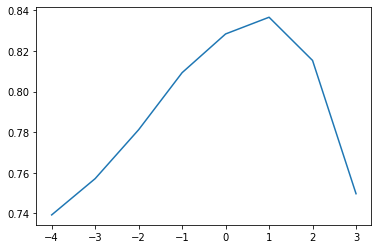

In [30]:
#Accuracy curve for testing data
import matplotlib.pyplot as plt 

#define x and y coordinates
x = np.arange(-4, 4, 1)
y = np.array(accuracy_table)
fig, ax = plt.subplots()

plt.plot(x, y)
plt.savefig('testint_accuracies.png', bbox_inches='tight')

Question- 3

In [31]:
def classify_new_document_laplace10(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum, a):
  
  pos_probability = 0
  neg_probability = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = log((pos_word_counts[word] + 10)/(pos_sum + 10 * len(vocab))) + pos_probability
    else:
      pos_probability = log(10/ (pos_sum + 10 * len(vocab))) + pos_probability
    if word in neg_word_counts.keys():
      neg_probability = log((neg_word_counts[word] + 10)/(neg_sum + 10 * len(vocab))) + neg_probability
    else:
      neg_probability = log(10/ (neg_sum + 10 * len(vocab))) + neg_probability

  pos_test_probability = pos_probability + pos_label_prob
  neg_test_probability = neg_probability + neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [32]:
def evaluation_metrics_laplace10(x, y):
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(x, y)  
  (pos_test, neg_test) = load_test_set(x, y)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document in pos_test:
    test_value = classify_new_document_laplace10(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document in neg_test:
    test_value = classify_new_document_laplace10(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0]) 

  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])

  return accuracy, confusion_matrix, precision, recall

In [33]:
accuracy_log_100, confusion_matrix_log_100, precision_log_100, recall_log_100 = evaluation_metrics_laplace(1.0, 1.0)

In [34]:
accuracy_log_100

0.82348

In [35]:
confusion_matrix_log_100

matrix([[ 9559,  2941],
        [ 1472, 11028]])

In [36]:
precision_log_100

0.8665578823316109

In [37]:
recall_log_100

0.76472

Question - 4

In [38]:
def classify_new_document_laplace50(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum):
  
  pos_probability = 0
  neg_probability = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = log((pos_word_counts[word] + 10)/(pos_sum + 10 * len(vocab))) + pos_probability
    else:
      pos_probability = log(10/ (pos_sum + 10 * len(vocab))) + pos_probability
    if word in neg_word_counts.keys():
      neg_probability = log((neg_word_counts[word] + 10)/(neg_sum + 10 * len(vocab))) + neg_probability
    else:
      neg_probability = log(10/ (neg_sum + 10 * len(vocab))) + neg_probability

  pos_test_probability = pos_probability + pos_label_prob
  neg_test_probability = neg_probability + neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [56]:
def evaluation_metrics_laplace50():
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(0.5, 0.5)  
  (pos_test, neg_test) = load_test_set(1.0, 1.0)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document in pos_test:
    test_value = classify_new_document_laplace50(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document in neg_test:
    test_value = classify_new_document_laplace50(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0]) 

  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])

  return accuracy, confusion_matrix, precision, recall

In [57]:
accuracy_lap_50, confusion_matrix_lap_50, precision_lap_50, recall_lap_50 = evaluation_metrics_laplace50()

In [54]:
accuracy_lap_25, confusion_matrix_lap_25, precision_lap_25, recall_lap_25 = evaluation_metrics_laplace50()

In [55]:
accuracy_lap_25

0.8094

In [41]:
accuracy_lap_50

0.83428

In [42]:
confusion_matrix_lap_50

matrix([[ 9783,  2717],
        [ 1426, 11074]])

In [43]:
precision_lap_50

0.8727808011419396

In [44]:
recall_lap_50

0.78264

Question-6


In [45]:
def classify_new_document_laplace_imbalance(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum):
  
  pos_probability = 0
  neg_probability = 0

  #probabilities of class labels
  pos_label_prob = len(pos_train)/ (len(pos_train)+len(neg_train))
  neg_label_prob = len(neg_train)/ (len(pos_train)+len(neg_train))
  
  #Probabilities product for each word in test document
  for word in test_document:
    if word in pos_word_counts.keys():
      pos_probability = log((pos_word_counts[word] + 10)/(pos_sum + 10 * len(vocab))) + pos_probability
    else:
      pos_probability = log(10/ (pos_sum + 10 * len(vocab))) + pos_probability
    if word in neg_word_counts.keys():
      neg_probability = log((neg_word_counts[word] + 10)/(neg_sum + 10 * len(vocab))) + neg_probability
    else:
      neg_probability = log(10/ (neg_sum + 10 * len(vocab))) + neg_probability

  pos_test_probability = pos_probability + pos_label_prob
  neg_test_probability = neg_probability + neg_label_prob
  if pos_test_probability > neg_test_probability:
    return 1
  else:
    return 0


In [46]:
def evaluation_metrics_laplace_imbalance():
  #loading training data and test data
  (pos_train, neg_train, vocab) = load_training_set(0.1, 0.5)  
  (pos_test, neg_test) = load_test_set(1, 1)
  
  #initializing factors for accuracy, pecision, and recall
  pos_accuracy_counter = 0
  neg_accuracy_counter = 0 

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #counter table for class labels and sum of all counts
  pos_word_counts, pos_sum = counter_table(pos_train)
  neg_word_counts, neg_sum = counter_table(neg_train)

  # Evaluation for positive test data
  for test_document in pos_test:
    test_value = classify_new_document_laplace_imbalance(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 1:
      pos_accuracy_counter +=1
      confusion_matrix[0,0] += 1
    else:
      confusion_matrix[0,1] +=1

  #Evaluation for negative test data
  for test_document in neg_test:
    test_value = classify_new_document_laplace_imbalance(test_document, pos_train, vocab, neg_train, pos_word_counts, pos_sum, neg_word_counts, neg_sum)
    if test_value == 0:
      neg_accuracy_counter +=1
      confusion_matrix[1,1] +=1
    else:
      confusion_matrix[1,0] +=1

  #calculating accuracy of the model
  accuracy = (pos_accuracy_counter + neg_accuracy_counter)/(len(pos_test)+ len(neg_test))

  #calculating precision of the model
  precision = confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0]) 

  #calculating recall of the model
  recall = confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1])

  return accuracy, confusion_matrix, precision, recall

In [47]:
accuracy_lap_imbalance, confusion_matrix_lap_imbalance, precision_lap_imbalance, recall_lap_imbalance = evaluation_metrics_laplace_imbalance()

In [48]:
accuracy_lap_imbalance

0.5002

In [49]:
confusion_matrix_lap_imbalance

matrix([[    6, 12494],
        [    1, 12499]])

In [50]:
precision_lap_imbalance

0.8571428571428571

In [51]:
recall_lap_imbalance

0.00048